In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import numpy as np
from scipy.spatial.transform import Rotation as R
import torch
from torch.utils.data import Dataset, DataLoader

In [8]:
phi = (np.sqrt(5)+1)/2 #golden angle helps define verticies of icosahedron
icosahedral_group = R.create_group('I') #rotation group only, 60 elements
print(f'Number of rotations in icosahedral group: {len(icosahedral_group)}')
rotation_matrices = icosahedral_group.as_matrix()
d=1/3
initial_point = (1-d)*np.array([1,phi,0])+d*np.array([0,1+2*phi,phi])
#initial_point = np.array([1,1+3*phi,phi]) #This point does not lie on any axes of symmetry
second_point = np.array([1,1+phi,phi])
second_point = second_point/np.linalg.norm(second_point)
third_point = np.array([1,phi,0])
third_point = third_point/np.linalg.norm(third_point)
initial_point = initial_point/np.linalg.norm(initial_point)
orbit = []

for M in rotation_matrices: #apply every rotation to point
    new_point = M@initial_point
    orbit.append(new_point)

for M in rotation_matrices: #apply every rotation to second point
    new_point = M@second_point
    orbit.append(new_point)

for M in rotation_matrices: #apply every rotation to second point
    new_point = M@third_point
    orbit.append(new_point)

print(f'Length of orbit: {len(orbit)}')
unique_orbit = np.unique(np.array(orbit), axis=0) #check uniqueness, in case of accidentally generating a subgroup
print(f'Unique points in orbit: {np.array(unique_orbit).shape[0]}')
x, y, z = np.array(orbit).T
print(initial_point)


Number of rotations in icosahedral group: 60
Length of orbit: 180
Unique points in orbit: 166
[0.25308174 0.9455306  0.20474743]
[[ 0.30901699 -0.80901699  0.5       ]
 [-0.80901699 -0.5        -0.30901699]
 [ 0.5        -0.30901699 -0.80901699]]


In [39]:
import numpy as np

def half_sphere(p):
    # Ensure p is a numpy array for element-wise operations
    p = np.array(p)
    
    # Handle the case when p[0] is 0 to avoid division by zero
    theta = np.arctan2(p[1], p[0])  # arctan2 handles division by zero and all quadrants
    phi = np.arccos(p[2] / np.linalg.norm(p))  # Normalize p[2] to the length of p for safety

    return 1 if 0 < theta < np.pi else 0

def great_band(p):
    p = np.array(p) / np.linalg.norm(p)
    
    
    theta = np.arctan2(p[1], p[0])  # Azimuthal angle
    phi = np.arccos(p[2])  # Polar angle
    
    
    band_half_width = np.pi / 6  
    
    # Return 1 if the point is within the band, else return 0
    if (phi > (np.pi / 2 - band_half_width)) and (phi < (np.pi / 2 + band_half_width)):
        return 1
    else:
        return 0

def checkerboard(p):
    p = np.array(p) / np.linalg.norm(p)
    
    theta = np.arctan2(p[1], p[0])  # Azimuthal angle
    phi = np.arccos(p[2])  # Polar angle
    
    theta = theta % (2 * np.pi)
    
    # Define the number of divisions in each direction
    # More divisions will create a finer checkerboard pattern
    divisions_theta = 4  # Divisions in azimuthal direction
    divisions_phi = 2  # Divisions in polar direction
    
    # Calculate the width of each division
    width_theta = (2 * np.pi) / divisions_theta
    width_phi = np.pi / divisions_phi
    
    # Determine the index of the division each angle falls into
    index_theta = int(theta // width_theta)
    index_phi = int(phi // width_phi)
    
    # Return 1 if the sum of the indices is even (checkerboard pattern), else return 0
    return 1 if (index_theta + index_phi) % 2 == 0 else 0

def polar_caps(p, cap_width=np.pi/3):
    p = np.array(p) / np.linalg.norm(p)
    phi = np.arccos(p[2])  # Polar angle
    if phi < cap_width or phi > (np.pi - cap_width):
        return 1 
    return 0  




half_sphere_output = np.array([half_sphere(point) for point in orbit])
band_output = np.array([great_band(point) for point in orbit])
checkerboard_output = np.array([checkerboard(point) for point in orbit])
polar_caps_output = np.array([polar_caps(point) for point in orbit])

filtered_orbit_band = np.array(orbit)[band_output == 1]
filtered_orbit_checkerboard = np.array(orbit)[checkerboard_output == 1]
filtered_orbit_polar_caps = np.array(orbit)[polar_caps_output == 1]
filtered_orbit_half_sphere = np.array(orbit)[half_sphere_output == 1]
print(f'band: {filtered_orbit_band.shape}, half-sphere: {filtered_orbit_half_sphere.shape}, checkerboard: {filtered_orbit_checkerboard.shape}, polar caps: {filtered_orbit_polar_caps.shape}')


band: (72, 3), half-sphere: (78, 3), checkerboard: (92, 3), polar caps: (92, 3)


In [40]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create a 2x2 subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}],
                                           [{'type': 'scatter3d'}, {'type': 'scatter3d'}]])

# Subplot 1: Polar Caps
fig.add_trace(go.Scatter3d(x=x[polar_caps_output == 1], y=y[polar_caps_output == 1], z=z[polar_caps_output == 1], mode='markers', marker=dict(size=2, color='blue')), row=1, col=1)

# Subplot 2: Checkerboard
fig.add_trace(go.Scatter3d(x=x[checkerboard_output == 1], y=y[checkerboard_output == 1], z=z[checkerboard_output == 1], mode='markers', marker=dict(size=2, color='blue')), row=1, col=2)

# Subplot 3: Half-Sphere
fig.add_trace(go.Scatter3d(x=x[half_sphere_output == 1], y=y[half_sphere_output == 1], z=z[half_sphere_output == 1], mode='markers', marker=dict(size=2, color='blue')), row=2, col=1)

# Subplot 4: Band
fig.add_trace(go.Scatter3d(x=x[band_output == 1], y=y[band_output == 1], z=z[band_output == 1], mode='markers', marker=dict(size=2, color='blue')), row=2, col=2)

# Update layout for a better view
fig.update_layout(height=800, width=800, title_text="Different Spherical Shapes")
fig.show()


In [41]:
import torch
from torch.utils.data import Dataset, DataLoader

class ShapeDataset(Dataset):
    def __init__(self, sequences, labels):
        """
        sequences: A list of binary sequences, each representing a shape.
        labels: A list of integers, labels for each sequence.
        """
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


In [42]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(180, 128)  # Input layer
        self.fc2 = nn.Linear(128, 64)   # Hidden layer
        self.fc3 = nn.Linear(64, 4)     # Output layer for 4 classes

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [43]:
sequences = np.array([half_sphere_output, band_output, polar_caps_output, checkerboard_output])
labels = [0,1,2,3]

dataset = ShapeDataset(sequences, labels)
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000  # Adjust as necessary
for epoch in range(num_epochs):
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 1.3818868398666382
Epoch 2, Loss: 1.3320045471191406
Epoch 3, Loss: 1.290358543395996
Epoch 4, Loss: 1.248523473739624
Epoch 5, Loss: 1.2059574127197266
Epoch 6, Loss: 1.163787841796875
Epoch 7, Loss: 1.1181671619415283
Epoch 8, Loss: 1.0702389478683472
Epoch 9, Loss: 1.0202968120574951
Epoch 10, Loss: 0.9700470566749573
Epoch 11, Loss: 0.9177461862564087
Epoch 12, Loss: 0.8644505739212036
Epoch 13, Loss: 0.8089706897735596
Epoch 14, Loss: 0.7526702284812927
Epoch 15, Loss: 0.696197509765625
Epoch 16, Loss: 0.6397899389266968
Epoch 17, Loss: 0.5837811827659607
Epoch 18, Loss: 0.527787446975708
Epoch 19, Loss: 0.4721311330795288
Epoch 20, Loss: 0.41777676343917847
Epoch 21, Loss: 0.3654927611351013
Epoch 22, Loss: 0.3163163959980011
Epoch 23, Loss: 0.2706420123577118
Epoch 24, Loss: 0.22909128665924072
Epoch 25, Loss: 0.1919882446527481
Epoch 26, Loss: 0.15949563682079315
Epoch 27, Loss: 0.13158336281776428
Epoch 28, Loss: 0.10774515569210052
Epoch 29, Loss: 0.08788274973

In [44]:
import numpy as np

def calculate_accuracy(y_pred, y_true):
    predicted_classes = torch.argmax(y_pred, dim=1)
    correct_predictions = torch.eq(predicted_classes, y_true).sum().item()
    accuracy = correct_predictions / y_true.shape[0]
    return accuracy

train_losses = []
test_losses = []
train_error_rates = []
test_error_rates = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, targets)
    
    train_losses.append(train_loss / len(train_dataloader))
    train_error_rates.append(1 - (train_accuracy / len(train_dataloader)))
    
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    with torch.no_grad():
        for inputs, targets in train_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            test_accuracy += calculate_accuracy(outputs, targets)
    
    test_losses.append(test_loss / len(train_dataloader))
    test_error_rates.append(1 - (test_accuracy / len(train_dataloader)))
    
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}, Train Error Rate: {train_error_rates[-1]}, Test Error Rate: {test_error_rates[-1]}")


Epoch 1, Train Loss: 1.3470521480485331e-05, Test Loss: 1.3440719158097636e-05, Train Error Rate: 0.0, Test Error Rate: 0.0
Epoch 2, Train Loss: 1.3440719158097636e-05, Test Loss: 1.3381115422816947e-05, Train Error Rate: 0.0, Test Error Rate: 0.0
Epoch 3, Train Loss: 1.3381115422816947e-05, Test Loss: 1.3381115422816947e-05, Train Error Rate: 0.0, Test Error Rate: 0.0
Epoch 4, Train Loss: 1.3381116332311649e-05, Test Loss: 1.3381115422816947e-05, Train Error Rate: 0.0, Test Error Rate: 0.0
Epoch 5, Train Loss: 1.3381115422816947e-05, Test Loss: 1.3351314009923954e-05, Train Error Rate: 0.0, Test Error Rate: 0.0
Epoch 6, Train Loss: 1.3351314009923954e-05, Test Loss: 1.3291710274643265e-05, Train Error Rate: 0.0, Test Error Rate: 0.0
Epoch 7, Train Loss: 1.3291710274643265e-05, Test Loss: 1.3291710274643265e-05, Train Error Rate: 0.0, Test Error Rate: 0.0
Epoch 8, Train Loss: 1.3291710274643265e-05, Test Loss: 1.326190795225557e-05, Train Error Rate: 0.0, Test Error Rate: 0.0
Epoch 9, 

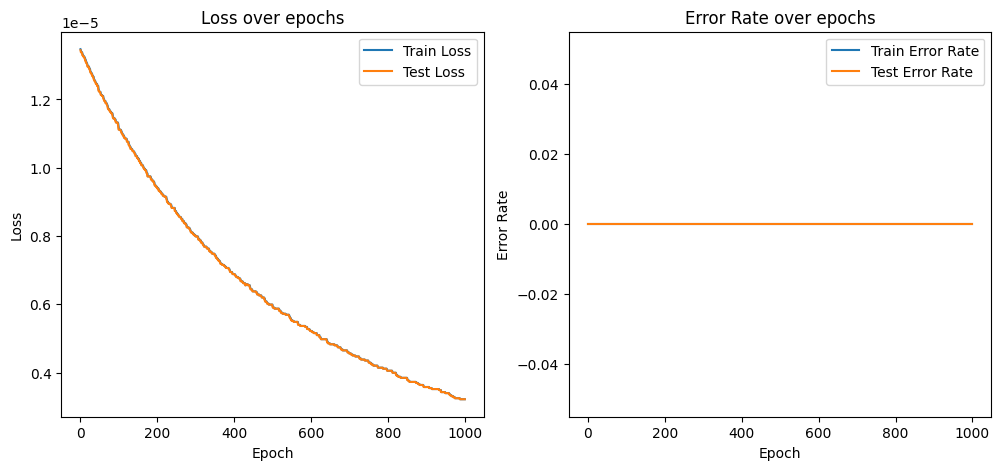

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_error_rates, label='Train Error Rate')
plt.plot(test_error_rates, label='Test Error Rate')
plt.title('Error Rate over epochs')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()

plt.show()


In [71]:
orbit1 = half_sphere_output[:60]
orbit2 = half_sphere_output[60:120]
orbit3 = half_sphere_output[120:]

shift_by = [3,5,6,10,13,17,21,22,23,29,30,41,47,55,58]
for shift in shift_by:
    test_accuracy = 0.0
    orbit1_rolled = np.roll(orbit1, shift)
    orbit2_rolled = np.roll(orbit2, shift)
    orbit3_rolled = np.roll(orbit3, shift)
    half_sphere_rolled = torch.tensor(list(orbit1_rolled) + list(orbit2_rolled) + list(orbit3_rolled), dtype = torch.float32)
    #print(half_sphere_rolled.shape)
    outputs = model(half_sphere_rolled)
    #print(outputs)
    print(f'Probabilities (correct label is index 0): {torch.softmax(outputs, dim=0)[0]}')
    
    

Probabilities (correct label is index 0): 0.8462716937065125
Probabilities (correct label is index 0): 0.8229128122329712
Probabilities (correct label is index 0): 0.13534393906593323
Probabilities (correct label is index 0): 0.014202769845724106
Probabilities (correct label is index 0): 0.07615182548761368
Probabilities (correct label is index 0): 0.013588770292699337
Probabilities (correct label is index 0): 0.01116337813436985
Probabilities (correct label is index 0): 0.015368434600532055
Probabilities (correct label is index 0): 0.023910868912935257
Probabilities (correct label is index 0): 0.26403290033340454
Probabilities (correct label is index 0): 0.8921283483505249
Probabilities (correct label is index 0): 0.005871458910405636
Probabilities (correct label is index 0): 0.04214233160018921
Probabilities (correct label is index 0): 0.25380846858024597
Probabilities (correct label is index 0): 0.911517322063446
